# Denoising scRNA-seq using DCA

## scRNA-seq Simulation using Splatter R package and rpy2

In [1]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [2]:
import os

r_home = "/Library/Frameworks/R.framework/Resources"
r_path = r"/Library/Frameworks/R.framework/Resources/bin"

os.environ["R_HOME"] = r_home
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

### Simulate two groups using Splatter

In [3]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo

# make sure that splatter is installed: https://github.com/Oshlack/splatter
library(splatter)

simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=3)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups

    # new splatter requires dropout.type
    if ('dropout.type' %in% slotNames(newSplatParams())) {
        if (dropout)
            dropout.type <- 'experiment'
        else
            dropout.type <- 'none'
        
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.type=dropout.type, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)

    } else {
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.present=!dropout, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)        
    }

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    # mode(dropout) <- 'integer'

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowC

## Generate AnnData objects and analyze in Scanpy

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from dca.api import dca



Using TensorFlow backend.


In [6]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'

In [7]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'

In [8]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

## Denoise simulated data

In [9]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
dca(adata_ae, threads=1)

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)

dca: Successfully preprocessed 198 genes and 2000 cells.



2021-11-22 16:07:24,445 [WARNING] From /Users/johannes.ostner/Documents/PhD/cloned_github_repos/dca/dca/train.py:41: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

/Users/johannes.ostner/opt/anaconda3/envs/dca/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
CPU times: user 23.1 s, sys: 479 ms, total: 23.6 s
Wall time: 23.3 s


In [10]:
adata_ae

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'dca_split', 'n_counts', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## PCA: Simulation with and without dropout effect

... storing 'Batch' as categorical


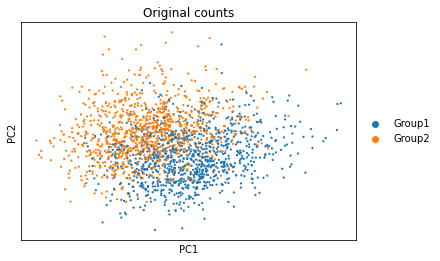

... storing 'Batch' as categorical


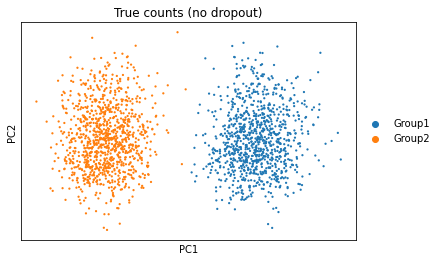

... storing 'Batch' as categorical


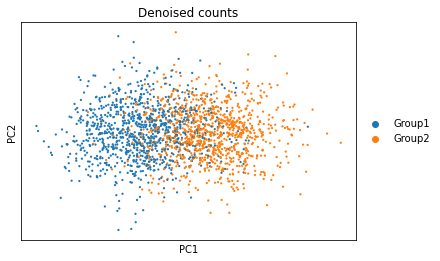

In [11]:
sc.pl.pca_scatter(adata, color='Group', size=20, title='Original counts')
sc.pl.pca_scatter(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.pca_scatter(adata_ae, color='Group', size=20, title='Denoised counts')

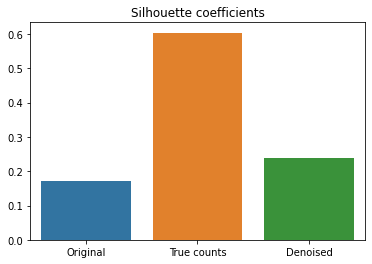

In [12]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm['X_pca'][:, :2], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm['X_pca'][:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm['X_pca'][:, :2], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], 
            y=[sil_orig, sil_true, sil_ae])

plt.title('Silhouette coefficients');

In [13]:
adata._sanitize()
adata_ae._sanitize()

In [14]:
adata.obs.Group

Cell
Cell1       Group1
Cell2       Group1
Cell3       Group2
Cell4       Group1
Cell5       Group1
             ...  
Cell1996    Group2
Cell1997    Group2
Cell1998    Group2
Cell1999    Group2
Cell2000    Group1
Name: Group, Length: 2000, dtype: category
Categories (2, object): ['Group1', 'Group2']

/Users/johannes.ostner/opt/anaconda3/envs/dca/lib/python3.6/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


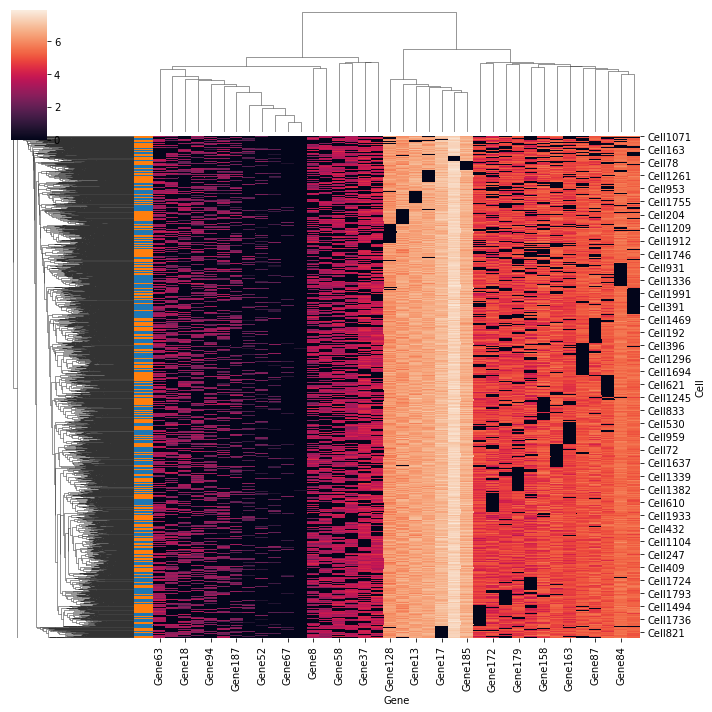

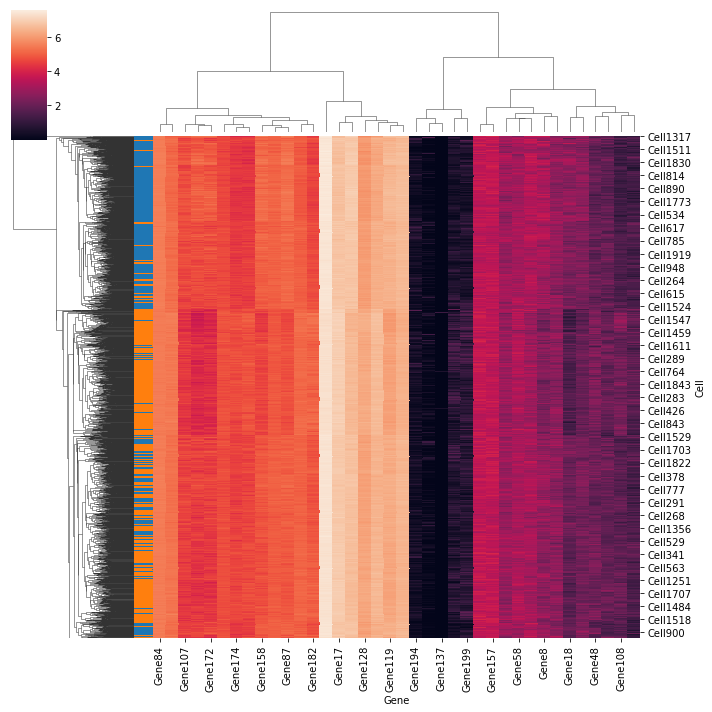

In [15]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)

## Simulate six groups

In [16]:
%%R -o counts -o geneinfo -o cellinfo -o truecounts

sim <- simulate(nGroups=6, dropout=1)

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

2021-11-22 16:07:50,775 [WARNING] R[write to console]: Getting parameters...

2021-11-22 16:07:50,796 [WARNING] R[write to console]: Creating simulation object...

2021-11-22 16:07:51,019 [WARNING] R[write to console]: Simulating library sizes...

2021-11-22 16:07:51,054 [WARNING] R[write to console]: Simulating gene means...

2021-11-22 16:07:51,197 [WARNING] R[write to console]: Simulating group DE...

2021-11-22 16:07:51,344 [WARNING] R[write to console]: Simulating cell means...

2021-11-22 16:07:51,463 [WARNING] R[write to console]: Simulating BCV...

2021-11-22 16:07:51,584 [WARNING] R[write to console]: Simulating counts...

2021-11-22 16:07:51,656 [WARNING] R[write to console]: Simulating dropout (if needed)...

2021-11-22 16:07:51,810 [WARNING] R[write to console]: Sparsifying assays...

2021-11-22 16:07:51,812 [WARNING] R[write to console]: Automatically converting to sparse matrices, threshold = 0.95

2021-11-22 16:07:51,825 [WARNING] R[write to console]: Skipping 'BatchCell

In [17]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)

adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6'

In [18]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

sc.tl.tsne(adata)
sc.tl.tsne(adata_true)

## Denoise simulated data

In [19]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
dca(adata_ae, threads=1)

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.tl.tsne(adata_ae)

adata_ae

dca: Successfully preprocessed 198 genes and 2000 cells.


/Users/johannes.ostner/opt/anaconda3/envs/dca/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
         Falling back to preprocessing with `sc.pp.pca` and default params.


dca: Calculating reconstructions...
CPU times: user 1min 30s, sys: 1.52 s, total: 1min 32s
Wall time: 39.1 s


AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'dca_split', 'n_counts', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts', 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_pca', 'X_tsne'

... storing 'Batch' as categorical


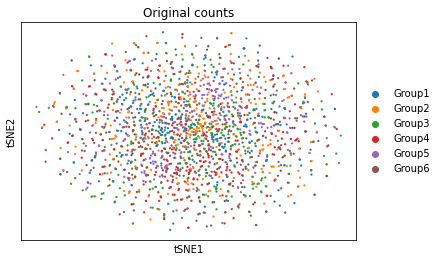

... storing 'Batch' as categorical


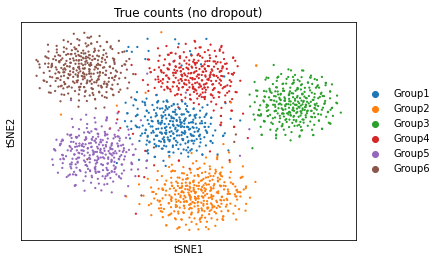

... storing 'Batch' as categorical


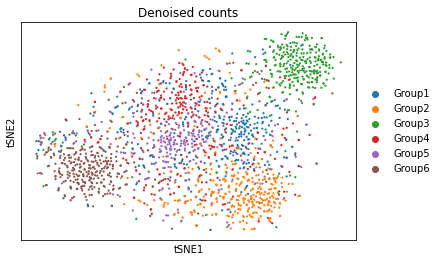

In [20]:
sc.pl.tsne(adata, color='Group', size=20, title='Original counts')
sc.pl.tsne(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.tsne(adata_ae, color='Group', size=20, title='Denoised counts')

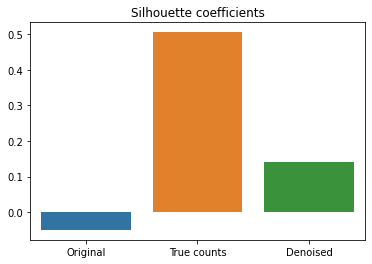

In [21]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm['X_tsne'], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm['X_tsne'], adata_true.obs.Group)
sil_ae   = silhouette_score(adata_ae.obsm['X_tsne'], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], y=[sil_orig, sil_true, sil_ae])
plt.title('Silhouette coefficients');

In [22]:
adata

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
    uns: 'log1p', 'pca', 'Group_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

/Users/johannes.ostner/opt/anaconda3/envs/dca/lib/python3.6/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


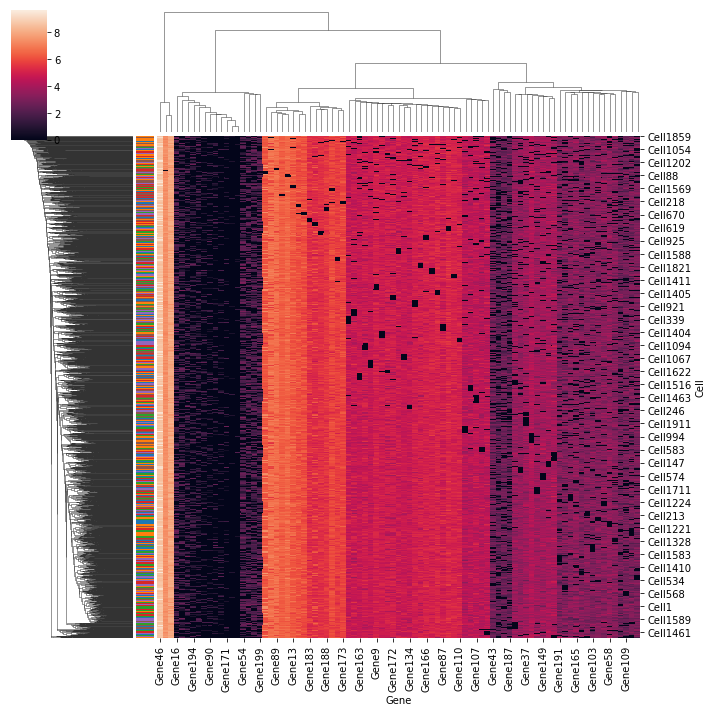

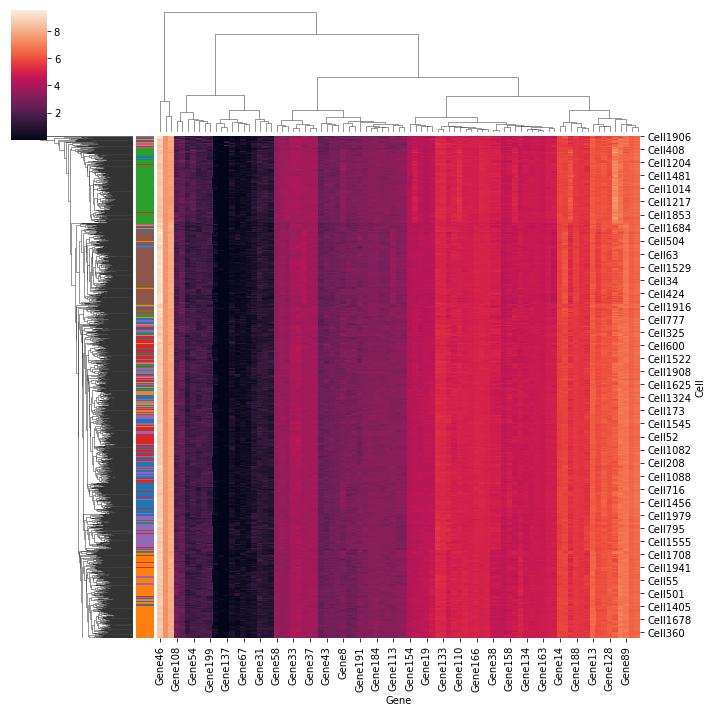

In [23]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)